# Exploring Clustering Methods: Using Credit Card Dataset


## Data Exploration <a class="anchor" id="first-bullet"></a>

First, let us import the required libraries.

In [262]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.cluster import mean_shift, estimate_bandwidth
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer, silhouette_visualizer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from tqdm import tqdm

In [263]:
import warnings
warnings.filterwarnings("ignore")

In [264]:
data = pd.read_csv('./CC GENERAL.csv')

Lets have a look at some rows of the dataset:

In [265]:
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


As one can easily see, teh dataset has 18 features with about 9000 samples.

In [266]:
data.shape

(8950, 18)

Now, we can see the data types of the features:

In [267]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

Lets have a copy of the data for the later use:

In [268]:
data_raw = data.copy()

In the following, we investigate the number of different values in all features to understand whether there exist any binary features or not. Furthermore, to decide which features are redundant and can be deleted.

In [269]:
unique_dict = dict()
for col in data.columns:
    unique_dict[col] = data[col].value_counts().count()

pd.Series(unique_dict).to_frame().rename(columns={0: 'Numebr of unique values'})

,Numebr of unique values
CUST_ID,8950
BALANCE,8871
BALANCE_FREQUENCY,43
PURCHASES,6203
ONEOFF_PURCHASES,4014
INSTALLMENTS_PURCHASES,4452
CASH_ADVANCE,4323
PURCHASES_FREQUENCY,47
ONEOFF_PURCHASES_FREQUENCY,47
PURCHASES_INSTALLMENTS_FREQUENCY,47


As one can see, we do not have any binary features. Furthermore, for each sample we have a CUST_ID which can be omitted wihtout losing any information. 

In [270]:
data.drop(columns=['CUST_ID'], axis=1, inplace=True)

In what follows, let's have a look at the pairwise correlation of columns:

In [271]:
data.corr().T

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
BALANCE,1.000000,0.322412,0.181261,0.164350,0.126469,0.496692,-0.077944,0.073166,-0.063186,0.449218,0.385152,0.154338,0.531283,0.322802,0.398684,-0.318959,0.072692
BALANCE_FREQUENCY,0.322412,1.000000,0.133674,0.104323,0.124292,0.099388,0.229715,0.202415,0.176079,0.191873,0.141555,0.189626,0.095843,0.065008,0.132569,-0.095082,0.119776
PURCHASES,0.181261,0.133674,1.000000,0.916845,0.679896,-0.051474,0.393017,0.498430,0.315567,-0.120143,-0.067175,0.689561,0.356963,0.603264,0.093860,0.180379,0.086288
ONEOFF_PURCHASES,0.164350,0.104323,0.916845,1.000000,0.330622,-0.031326,0.264937,0.524891,0.127729,-0.082628,-0.046212,0.545523,0.319724,0.567292,0.048755,0.132763,0.064150
INSTALLMENTS_PURCHASES,0.126469,0.124292,0.679896,0.330622,1.000000,-0.064244,0.442418,0.214042,0.511351,-0.132318,-0.073999,0.628108,0.256499,0.384084,0.132172,0.182569,0.086143
CASH_ADVANCE,0.496692,0.099388,-0.051474,-0.031326,-0.064244,1.000000,-0.215507,-0.086754,-0.177070,0.628522,0.656498,-0.075850,0.303985,0.453238,0.140107,-0.152935,-0.068312
PURCHASES_FREQUENCY,-0.077944,0.229715,0.393017,0.264937,0.442418,-0.215507,1.000000,0.501343,0.862934,-0.308478,-0.203478,0.568430,0.119788,0.103464,0.003030,0.305802,0.061506
ONEOFF_PURCHASES_FREQUENCY,0.073166,0.202415,0.498430,0.524891,0.214042,-0.086754,0.501343,1.000000,0.142329,-0.111716,-0.069088,0.544869,0.295038,0.243537,-0.030327,0.157531,0.082466
PURCHASES_INSTALLMENTS_FREQUENCY,-0.063186,0.176079,0.315567,0.127729,0.511351,-0.177070,0.862934,0.142329,1.000000,-0.262958,-0.169207,0.529975,0.060755,0.085551,0.030073,0.250087,0.073275
CASH_ADVANCE_FREQUENCY,0.449218,0.191873,-0.120143,-0.082628,-0.132318,0.628522,-0.308478,-0.111716,-0.262958,1.000000,0.799561,-0.131168,0.132616,0.183192,0.098838,-0.249773,-0.133372


The descriptive statistics of our dataset is as follows:

In [272]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000


Using histograms, one can see the distributions of the features in our dataset:

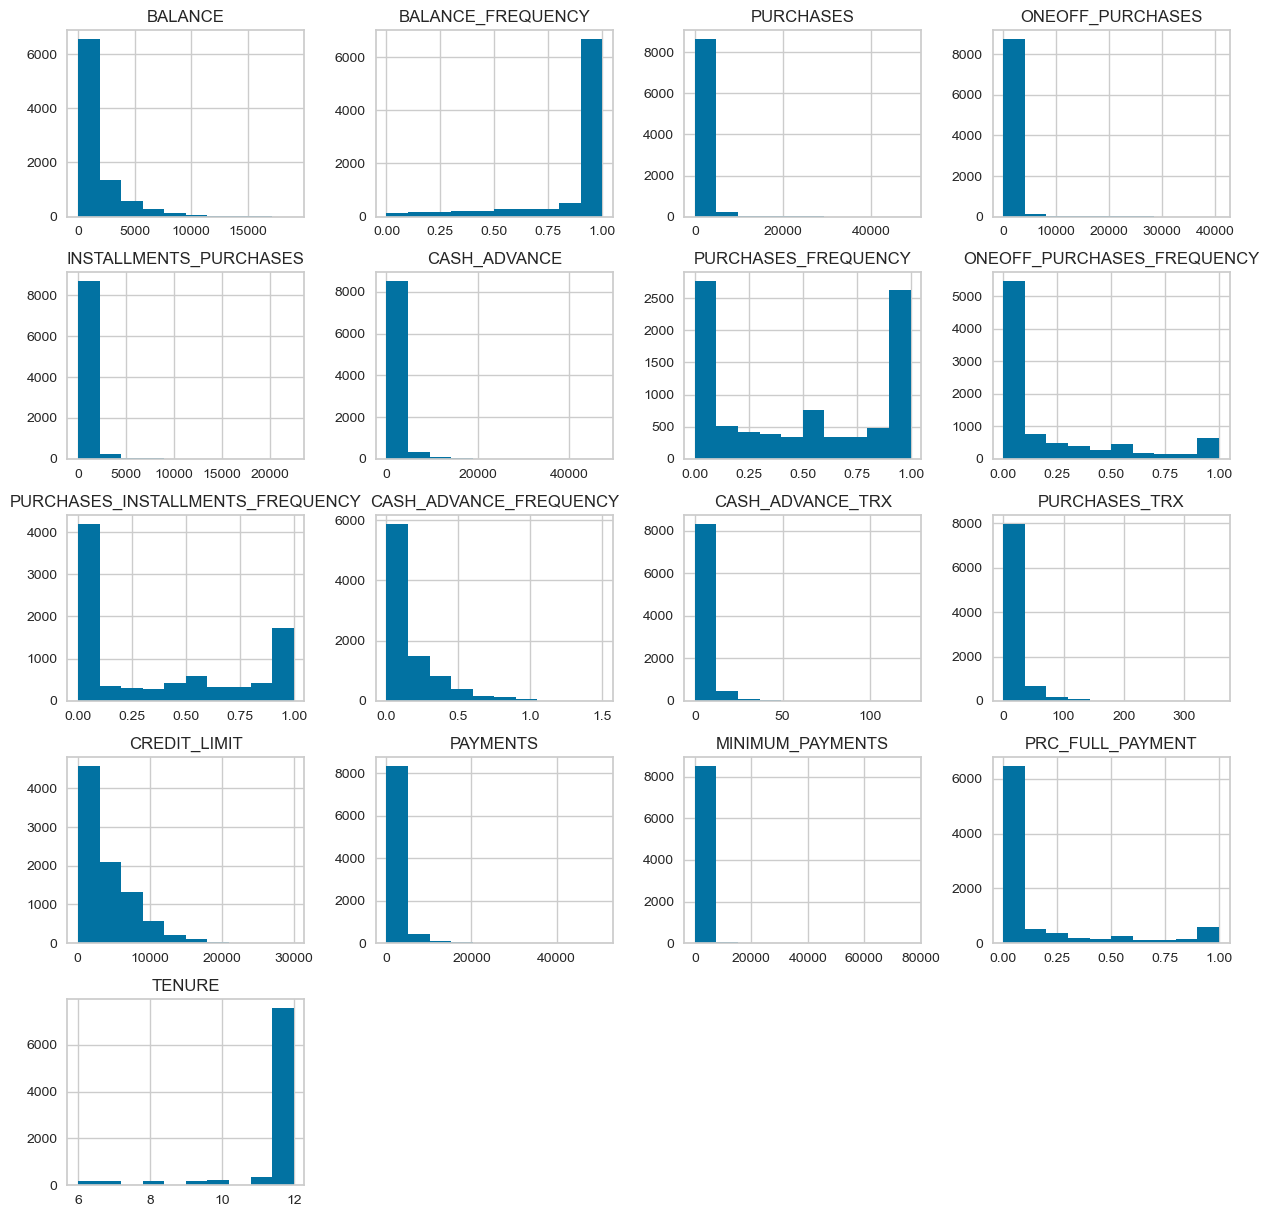

In [273]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
data.hist(figsize=(15, 15))
plt.show()


## Data Cleaning <a class="anchor" id="second-bullet"></a>

Now that we have have got familiar with the dataset, it is time to clean the data to tackle our problem:

### Handeling Skewness  <a class="anchor" id="21"></a>

As the first step to clean our data, lets investigate the skewness of our feature:

<Axes: >

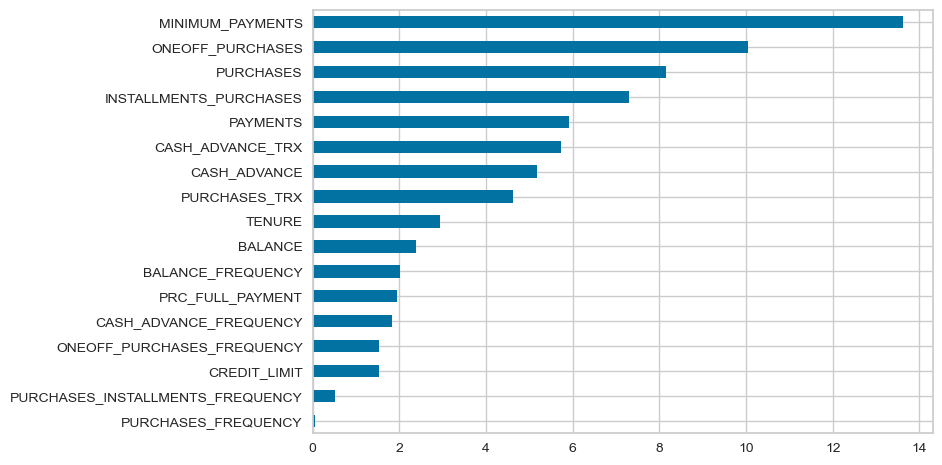

In [274]:
skew_val = data.skew().abs().sort_values()
skew_val.plot.barh()

As one can see, many of our features are highly skewed, and we have to take care of them. Using a log transformation, we can reduce the skewness of the features:

In [275]:
skewed_col = data.columns[skew_val>0.7]

<Axes: >

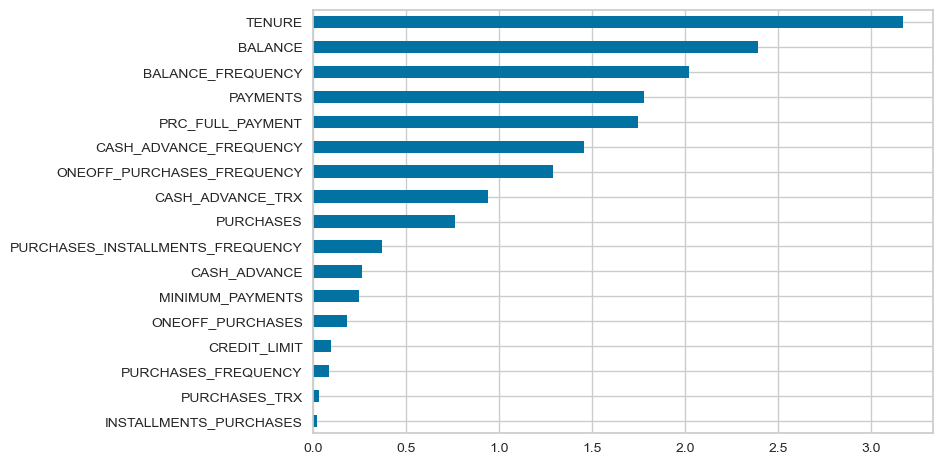

In [276]:
for col in skewed_col:
    data[col] = np.log1p(data[col])
    
skew_val = data.skew().abs().sort_values()
skew_val.plot.barh()

Employing the two barcharts provided above, it can be easily seen that the skewness has been decreases using the proposed transformation.

### Deleting Outliers <a class="anchor" id="22"></a>

In this subsection, we consider inspecting the outliers in our dataset. Using boxplots, we can display the distribution of the dataset and to visually detect the outliers in the dataset. 

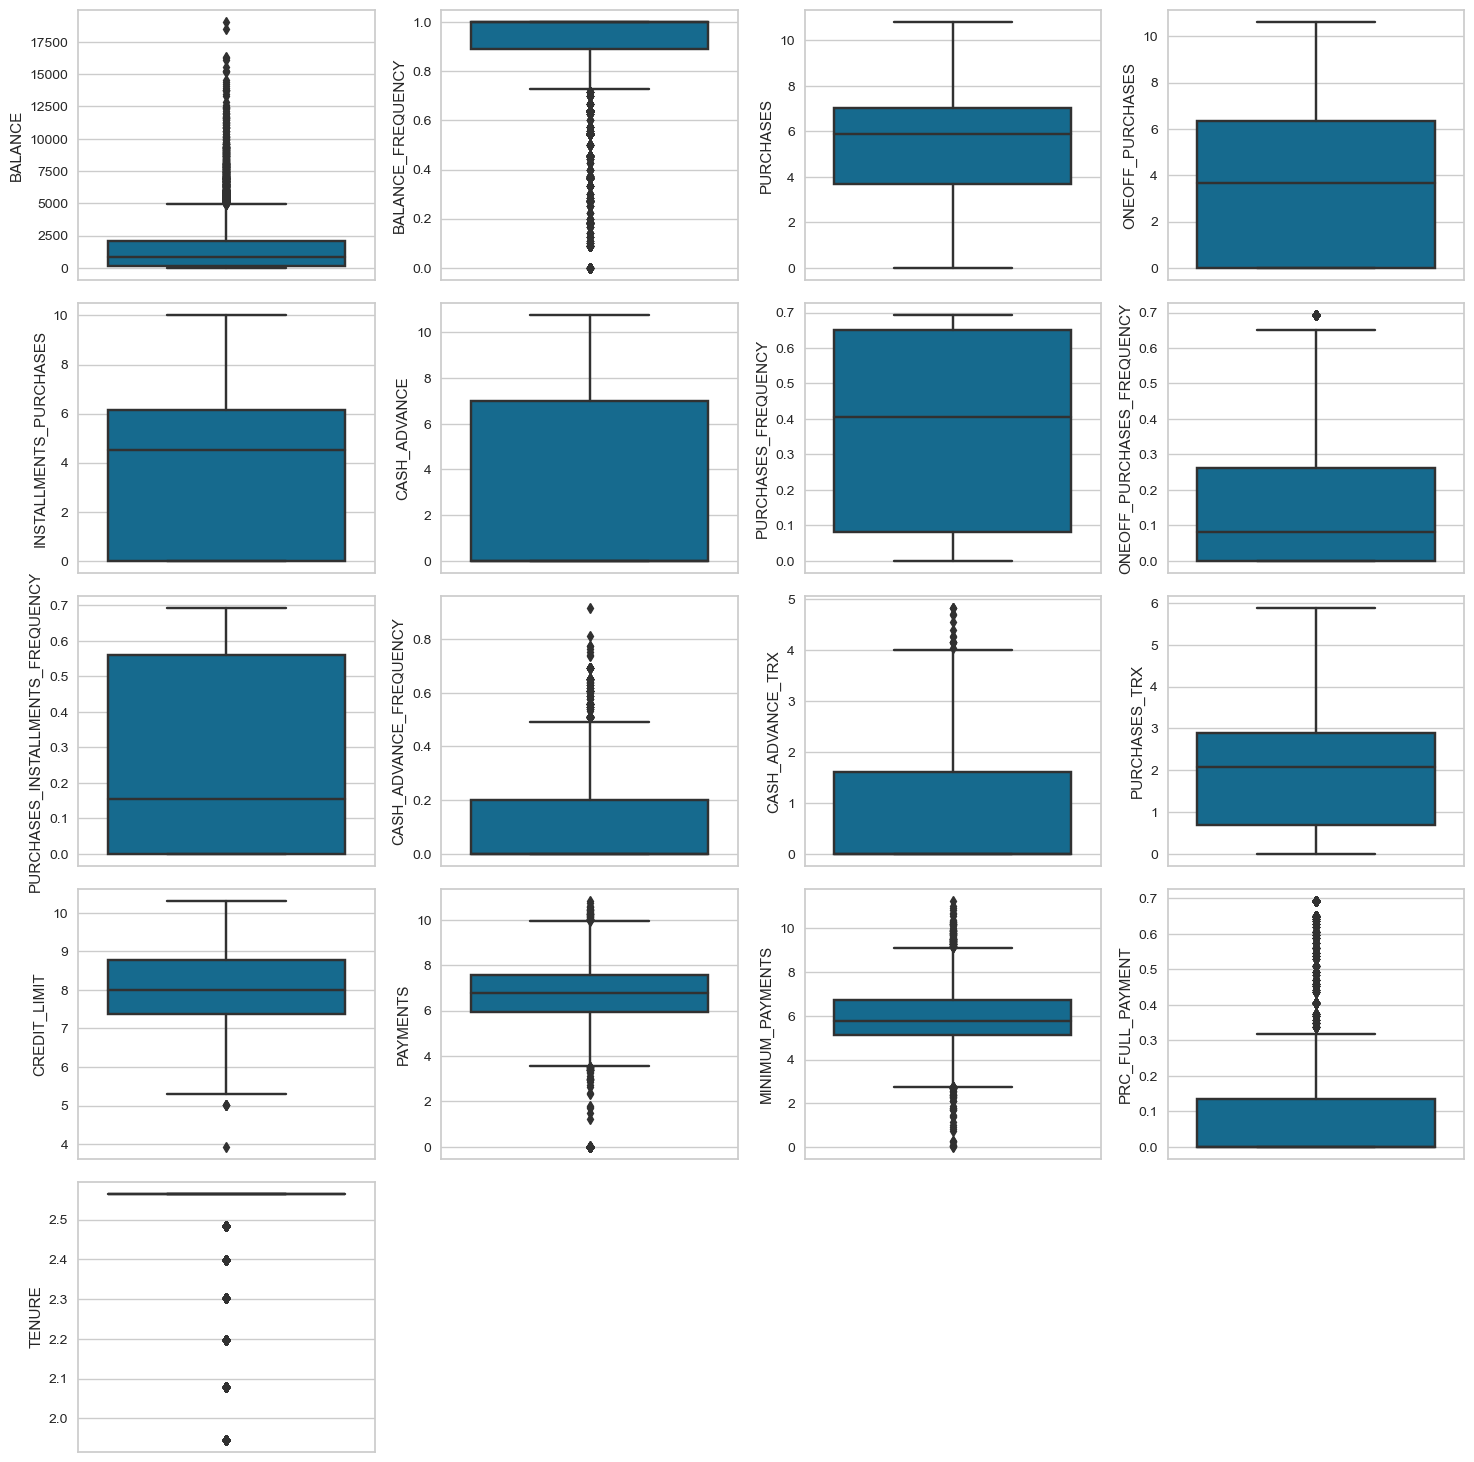

In [277]:
def bar_plot_rep(data):
    _, ax = plt.subplots(5,4, figsize=(15,15))
    for num, col in enumerate(data.columns):
        sns.boxplot(y=col, data=data, ax=ax.ravel()[num])
    
    plt.tight_layout()
    ax.ravel()[17].axis('off'), ax.ravel()[18].axis('off'), ax.ravel()[19].axis('off')
    plt.show()
    
bar_plot_rep(data)

We consider z-core=5 as a limit to delete the outliers in our dataset.

In [278]:
SScaler = StandardScaler()
data_scaled = SScaler.fit_transform(data)
mask = np.all(np.abs(data_scaled) < 5, axis=1)

data_del_outliers = data[mask]
data = data_del_outliers
data.shape

(8605, 17)

### Handling Null Values <a class="anchor" id="23"></a>

Let's again have a look at the features to see whether there exist any null values in our dataset.

In [279]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 8605 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8605 non-null   float64
 1   BALANCE_FREQUENCY                 8605 non-null   float64
 2   PURCHASES                         8605 non-null   float64
 3   ONEOFF_PURCHASES                  8605 non-null   float64
 4   INSTALLMENTS_PURCHASES            8605 non-null   float64
 5   CASH_ADVANCE                      8605 non-null   float64
 6   PURCHASES_FREQUENCY               8605 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8605 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8605 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8605 non-null   float64
 10  CASH_ADVANCE_TRX                  8605 non-null   float64
 11  PURCHASES_TRX                     8605 non-null   float64
 12  CREDIT_LIMI

### Applying PCA <a class="anchor" id="25"></a>

We consider PCA to reduce the dimension to improve the clustering performance. Suppose that we want to preserve 90 percent of the variance.  To do so, it is enough to consider 5 components in the PCA and 6 components in the PCA with Kernel, as it becomes clear below. PCA is used to find new standarized data based on relations between each variables.

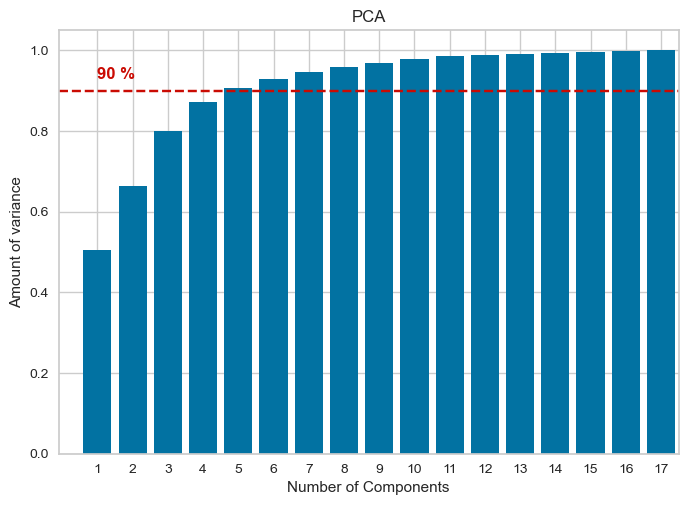

In [280]:
max_abs_scal = MaxAbsScaler()
pca = PCA(n_components=17, random_state=1979)

data_sca = max_abs_scal.fit_transform(data)
data_sca_tra = pca.fit_transform(data_sca)

res = pca.explained_variance_ratio_
plt.bar(x=np.arange(1,18), height=np.cumsum(res))
plt.text(1,0.93, '90 %', fontweight='bold', color='r')
plt.plot([-0.1, 17.5], [0.90,0.90], 'r--')
ax = plt.gca()
ax.set(xticks=np.arange(1,18), xlabel='Number of Components', ylabel='Amount of variance', title='PCA', xlim=[-0.1, 17.5])
plt.show()

### Applying PCA with Kernal <a class="anchor" id="25"></a>

PCA is not enough as ideally data can be quite varied and the relation maybe non-linear in nature. So PCA with kernel can identify non-linear relations. 

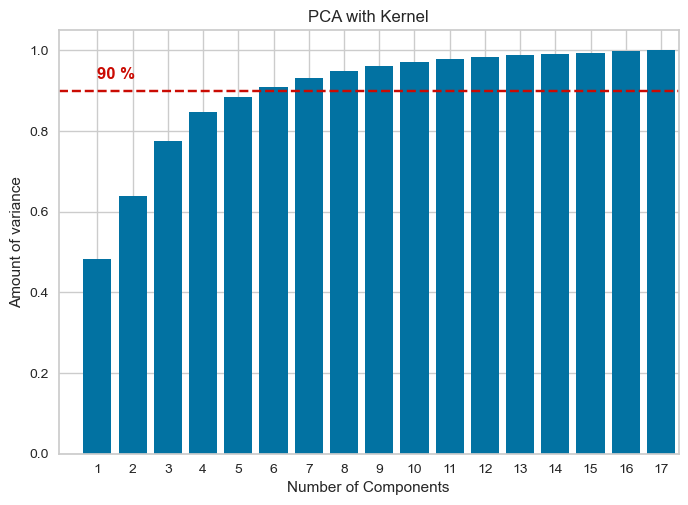

In [281]:
max_abs_scal = MaxAbsScaler()
kern_pca = KernelPCA(n_components=17, n_jobs=-1, kernel='rbf', random_state=1979)

data_sca = max_abs_scal.fit_transform(data)
data_sca_tra = kern_pca.fit_transform(data_sca)

explained_variance = np.var(data_sca_tra, axis=0)
res = explained_variance / np.sum(explained_variance)

plt.bar(x=np.arange(1,18), height=np.cumsum(res))


plt.text(1,0.93, '90 %', fontweight='bold', color='r')
plt.plot([-0.1, 17.5], [0.90,0.90], 'r--')
ax = plt.gca()
ax.set(xticks=np.arange(1,18), xlabel='Number of Components', ylabel='Amount of variance', title='PCA with Kernel', xlim=[-0.1, 17.5])
plt.show()



## Mean Shift Clustering <a class="anchor" id="34"></a>

The method that we have considered is the Mean Shift Clustering approach. Mean Shift essentially uses the Bandwidth values whihc is used to determine th esize of the nieghborhood used for clustering 

# 1. Evaluation Metrics for Mean Shift

In [282]:
def plot_num_cat(data, feature, target, figsize=None):
    fig = plt.figure(figsize=(15,6))

    for value in data[target].unique():
        sns.kdeplot(data[data[target]==value][feature])

    fig.legend(labels=data[target].unique())
    plt.title('{} distribution based on {}'.format(feature, target))
    plt.show()

In [284]:
from sklearn import metrics

def evaluate_clustering(labels, data):
    # Calculate Silhouette score
    silhouette_score = metrics.silhouette_score(data, labels, metric='euclidean')

    # Calculate Davies-Bouldin Index
    davies_bouldin_index = metrics.davies_bouldin_score(data, labels)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_index = metrics.calinski_harabasz_score(data, labels)

    return silhouette_score, davies_bouldin_index, calinski_harabasz_index

Shape of filtered_data: (8605, 17)


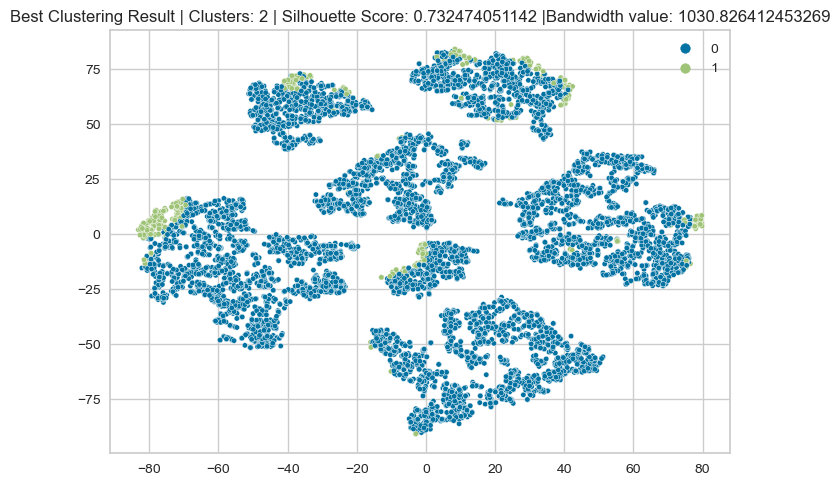

In [285]:
from sklearn.cluster import MeanShift
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import estimate_bandwidth
from sklearn.metrics import silhouette_score

# Create the Mean Shift object with bandwidth (similar to epsilon)
bandwidth = estimate_bandwidth(data, quantile=0.3, n_samples=None, random_state=1979, n_jobs=-1)
mean_shift = MeanShift(bandwidth=bandwidth)

# Fit the Mean Shift model to your scaled data
mean_shift.fit(data)

# Get cluster labels
cluster_labels = mean_shift.labels_

# Remove noise (label -1) data points
noise_mask = cluster_labels != -1
filtered_data = data[noise_mask]
filtered_labels = cluster_labels[noise_mask]

# Calculate silhouette score without noise
mean_shift_silhouette = silhouette_score(filtered_data, filtered_labels)

# Check the shape of filtered_data
print("Shape of filtered_data:", filtered_data.shape)

# Convert filtered_data to a NumPy array
filtered_data_np = filtered_data.values

import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

colors = sns.color_palette(n_colors=len(np.unique(filtered_labels)))
tsne = TSNE(n_components=2, learning_rate='auto', random_state=58).fit_transform(data_sca_tra)
sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], s=15, hue=filtered_labels, palette=colors)
plt.title(f'Best Clustering Result | Clusters: {len(np.unique(filtered_labels))} | Silhouette Score: {mean_shift_silhouette} |Bandwidth value: {bandwidth}' )
plt.show()


In [286]:
print(len(set(filtered_labels)))

2


In [287]:
# # I see alot of clusters
mean_shift_data = data[noise_mask].copy()
mean_shift_data['mean_shift_cluster'] = filtered_labels

In [288]:
cluster_mean_shift = mean_shift_data.groupby('mean_shift_cluster').mean().T
cm = sns.light_palette("red", as_cmap=True)
cluster_mean_shift = cluster_mean_shift.style.background_gradient(cmap=cm)
cluster_mean_shift

mean_shift_cluster,0,1
BALANCE,1222.873901,7571.564987
BALANCE_FREQUENCY,0.889087,0.994631
PURCHASES,4.938303,4.680824
ONEOFF_PURCHASES,3.213215,3.611259
INSTALLMENTS_PURCHASES,3.393306,3.208316
CASH_ADVANCE,3.139203,6.873733
PURCHASES_FREQUENCY,0.367339,0.321988
ONEOFF_PURCHASES_FREQUENCY,0.159818,0.180927
PURCHASES_INSTALLMENTS_FREQUENCY,0.274111,0.252860
CASH_ADVANCE_FREQUENCY,0.105400,0.281660


In [289]:
mean_shift_silhouette, mean_shift__davies_bouldin, mean_shift__calinski_harabasz = evaluate_clustering(filtered_labels, filtered_data )

print(f'mean_shift Silhouette score: {mean_shift_silhouette}')
print(f'mean_shift Davies-Bouldin Index: {mean_shift__davies_bouldin}')
print(f'mean_shift Calinski-Harabasz Index: {mean_shift__calinski_harabasz}')

mean_shift Silhouette score: 0.732474051142
mean_shift Davies-Bouldin Index: 0.3571284125953825
mean_shift Calinski-Harabasz Index: 9440.429372770075


# 2. Experimentation of the Mean Shift Clustering method

In [ ]:
def mean_shift_clusterer(X, random_state=1979, bandwidth=None, scaler=None, trans=None):
    
    if scaler:
        data_sca = scaler.fit_transform(X)
    else:
        data_sca = X
    
    if trans:
        data_sca_tra = trans.fit_transform(data_sca)
    else:
        data_sca_tra = data_sca 
    
    if bandwidth:
        pass
    else:
        bandwidth = estimate_bandwidth(data_sca_tra, quantile=0.3, n_samples=None, random_state=1979, n_jobs=-1)
    
    # Create the MeanShift object without specifying data
    mean_shift = MeanShift(bandwidth=bandwidth, n_jobs=-1)
    
    # Fit the MeanShift model to your data using the fit method
    mean_shift.fit(data_sca_tra)
    
    cluster_labels = mean_shift.labels_
    
    try:
        sil_score = silhouette_score(X=data_sca_tra, labels=cluster_labels)
    except:
        sil_score = np.nan
    
    return cluster_labels, sil_score, data_sca_tra

In [ ]:
pca = PCA(n_components=5, random_state=1979)

labels, sil_score, data_sca_tra = mean_shift_clusterer(data, random_state=1979, 
                                                       bandwidth=None, scaler=MaxAbsScaler(), trans=pca)

np.unique(labels, return_counts=True)

(array([0, 1]), array([3947, 4658]))

## Experimentation using different transformationn methods PCA or PCA with Kernel.

The code performs clustering for multiple combinations of bandwidth and transformer values and calculate the silouhette score for each. For each cluster label it picks out the value with the highest sillouhette score after testing with all possible bandwidth and Transformer type combinations. 

So for each cluster label, the combination with the highest sillouhette score is filtered out and the best transformer( PCA or Kernel PCA) is chosen and the mean shift clustering is performed once again on the most optimal combination to get the best performing clusters' cluster label and silhouette score and the best cluster label value is returned.

In [ ]:
def mean_shift_clusterer(X, random_state=1979, bandwidth=None, scaler=None, trans=None):
    
    ## if scaler is specified then the data is scaled using the scaler else X is assigned to data_sca
    if scaler:
        data_sca = scaler.fit_transform(X)
    else:
        data_sca = X
    
    ## if tranformarion method is specified then data is further transformed
    if trans:
        data_sca_tra = trans.fit_transform(data_sca)
    else:
        data_sca_tra = data_sca 
    
    ## if bandwidth is specified then specific bandwidth will be used else an estimate bandwidth is applied 
    if bandwidth:
        pass
    else:
        bandwidth = estimate_bandwidth(data_sca_tra, quantile=0.3, n_samples=None, random_state=1979, n_jobs=-1)
        ## the bandwidth is defined using 30% of the data . 
    
    cluster_centers, labels = mean_shift(X=data_sca_tra, n_jobs=-1, bandwidth=bandwidth)
    ## the cluster centers allocates the preprocceses data using bandwidth 
    try:
        sil_score = silhouette_score(X=data_sca_tra, labels=labels)
    except:
        sil_score = np.nan
    
    return labels, sil_score, data_sca_tra

In [ ]:
pca = PCA(n_components=4, random_state=1979)

labels, sil_score, data_sca_tra = mean_shift_clusterer(data, random_state=1979, 
                                                       bandwidth=None, scaler=MaxAbsScaler(), trans=pca)

np.unique(labels, return_counts=True)

In [ ]:
result_rows =[]
# Define transformers and bandwidths
pca = PCA(n_components=5, random_state=1979)
kern_pca = KernelPCA(n_components=4, n_jobs=-1, kernel='rbf')
transformers = [('PCA', pca), ('PCA with Kernel', kern_pca)]
bandwidths = np.geomspace(1e-3, 2, 50)

# Initialize variables to store the best results
best_silhouette_score = -1  # Initialize with a low value
best_labels = None
best_transformer = None
best_bandwidth = None
best_num_clusters = None

# Loop through transformers and bandwidths
for trans in transformers:
    for bandwidth in bandwidths:
        # Call mean_shift_clusterer function
        labels, sil_score, data_sca_tra = mean_shift_clusterer(data, random_state=1979, 
                                                           bandwidth=bandwidth, scaler=MaxAbsScaler(), trans=trans[1])
        
        # Check if this result has a higher silhouette score
        if sil_score > best_silhouette_score:
            best_silhouette_score = sil_score
            best_labels = labels
            best_transformer = trans[0]
            best_bandwidth = bandwidth
            best_num_clusters = len(np.unique(labels))
        # Create a new row with the results
        new_row = {'bandwidth': bandwidth, 'Transformer': trans[0], 'No. Classes': len(np.unique(labels)), 'Silhouette Score': sil_score}
        
        # Append the new row to the list
        result_rows.append(new_row)

# Create the DataFrame from the list of rows
res_mean_shift = pd.DataFrame(result_rows)

# Display the first few rows of the results DataFrame
res_mean_shift.head()

In [ ]:
def rep_MeanShift_result(NoClasses):
    idx = res_mean_shift[res_mean_shift['No. Classes'] == NoClasses]['Silhouette Score'].idxmax()
    opt_bandwidth = res_mean_shift[res_mean_shift['No. Classes'] == NoClasses].loc[idx, 'bandwidth']
    opt_trans = res_mean_shift[res_mean_shift['No. Classes'] == NoClasses].loc[idx, 'Transformer']

    if opt_trans == 'PCA':
        trans = pca
    else:
        trans = kern_pca

    labels, sil_score, data_sca_tra = mean_shift_clusterer(data, random_state=1979, bandwidth=opt_bandwidth,
                                                           scaler=MaxAbsScaler(), trans=trans)

    # Output the best clustering result
    print(f"Best Clustering Result:")
    print(f"Transformer: {opt_trans}")
    print(f"Bandwidth: {opt_bandwidth}")
    print(f"Number of Clusters: {NoClasses}")
    print(f"Silhouette Score: {sil_score}")

    # Plot the best clustering result
    colors = sns.color_palette(n_colors=NoClasses)
    tsne = TSNE(n_components=2, learning_rate='auto', random_state=58).fit_transform(data_sca_tra)
    sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], s=15, hue=labels, palette=colors)
    plt.title(f'Best Clustering Result | Clusters: {NoClasses} | Silhouette Score: {sil_score}')
    plt.show()

# Initialize an empty list to store rows
result_rows = []


Experiment 1: PCA with Estimated Bandwidth
Number of Clusters: 50
Silhouette Score: 0.28882471482129635


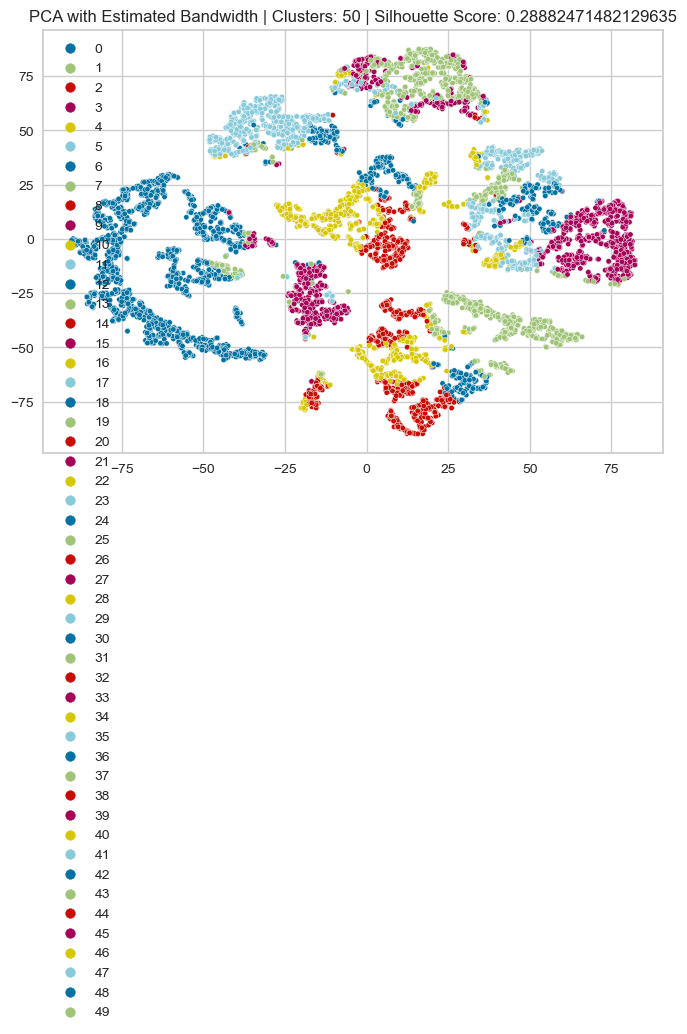

In [ ]:
# 1. Apply Mean Shift clustering with PCA and estimated bandwidth
pca = PCA(n_components=5, random_state=1979)
estimated_bandwidth = estimate_bandwidth(data_sca_tra, quantile=0.3, n_samples=None, random_state=1979, n_jobs=-1)
labels_pca, sil_score_pca, data_sca_tra_pca = mean_shift_clusterer(data, random_state=1979, bandwidth=estimated_bandwidth, scaler=MaxAbsScaler(), trans=pca)

# 2. Output the results
print("Experiment 1: PCA with Estimated Bandwidth")
print(f"Number of Clusters: {len(np.unique(labels_pca))}")
print(f"Silhouette Score: {sil_score_pca}")

# 3. Visualize the clustering results (you can use your existing visualization code)
colors_pca = sns.color_palette(n_colors=len(np.unique(labels_pca)))
tsne_pca = TSNE(n_components=2, learning_rate='auto', random_state=58).fit_transform(data_sca_tra_pca)
sns.scatterplot(x=tsne_pca[:, 0], y=tsne_pca[:, 1], s=15, hue=labels_pca, palette=colors_pca)
plt.title(f'PCA with Estimated Bandwidth | Clusters: {len(np.unique(labels_pca))} | Silhouette Score: {sil_score_pca}')
plt.show()


Experiment 2: PCA with Kernel and Estimated Bandwidth
Number of Clusters: 2
Silhouette Score: 0.37572176739225777


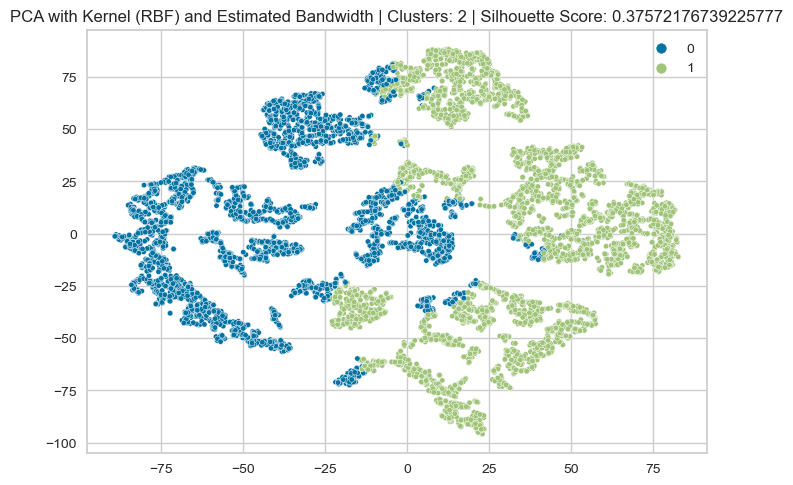

In [ ]:
# 1. Apply Mean Shift clustering with PCA and Kernel (RBF) and estimated bandwidth
kern_pca = KernelPCA(n_components=6, n_jobs=-1, kernel='rbf', random_state=1979)
estimated_bandwidth_kernel = estimate_bandwidth(data_sca_tra, quantile=0.3, n_samples=None, random_state=1979, n_jobs=-1)
labels_kernel, sil_score_kernel, data_sca_tra_kernel = mean_shift_clusterer(data, random_state=1979, bandwidth=estimated_bandwidth_kernel, scaler=MaxAbsScaler(), trans=kern_pca)

# 2. Output the results
print("Experiment 2: PCA with Kernel and Estimated Bandwidth")
print(f"Number of Clusters: {len(np.unique(labels_kernel))}")
print(f"Silhouette Score: {sil_score_kernel}")

# 3. Visualize the clustering results (you can use your existing visualization code)
colors_kernel = sns.color_palette(n_colors=len(np.unique(labels_kernel)))
tsne_kernel = TSNE(n_components=2, learning_rate='auto', random_state=58).fit_transform(data_sca_tra_kernel)
sns.scatterplot(x=tsne_kernel[:, 0], y=tsne_kernel[:, 1], s=15, hue=labels_kernel, palette=colors_kernel)
plt.title(f'PCA with Kernel (RBF) and Estimated Bandwidth | Clusters: {len(np.unique(labels_kernel))} | Silhouette Score: {sil_score_kernel}')
plt.show()